In [1]:
# realizando as importações das tecnologias que serão utilizadas
import pandas as pd
import numpy as np
import re
import cProfile
import nltk
import seaborn as sns
import matplotlib.pyplot as plt


from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# baixando as stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Lendo os dois Dataframes
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [4]:
# verificando se há algum valor nulo presente no dataframe de notícias verdadeiras
df_true.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [5]:
# verificando se há algum valor nulo presente o dataframe de notícias falsas
df_fake.isnull().sum()


,0
title,0
text,0
subject,0
date,0


In [6]:
#criando o campo class e passando como atributo 1 para noticias verdadeiras e 0 para falsas
df_true['class'] = 1
df_fake['class'] = 0

In [7]:
# concatenando os dataframes
news = pd.concat([df_true, df_fake], axis = 0)

In [ ]:
# verificando a concatenação
news.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


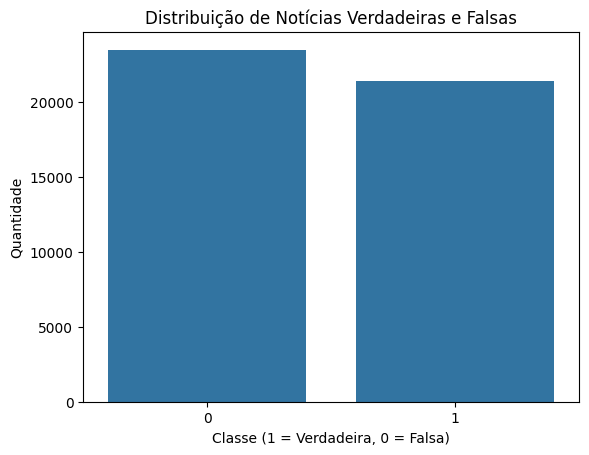

In [ ]:
# verificando a distribuição das noticias, percebemos que há uma predominância de notícias falsas
sns.countplot(data=news, x='class')
plt.title('Distribuição de Notícias Verdadeiras e Falsas')
plt.xlabel('Classe (1 = Verdadeira, 0 = Falsa)')
plt.ylabel('Quantidade')
plt.show()

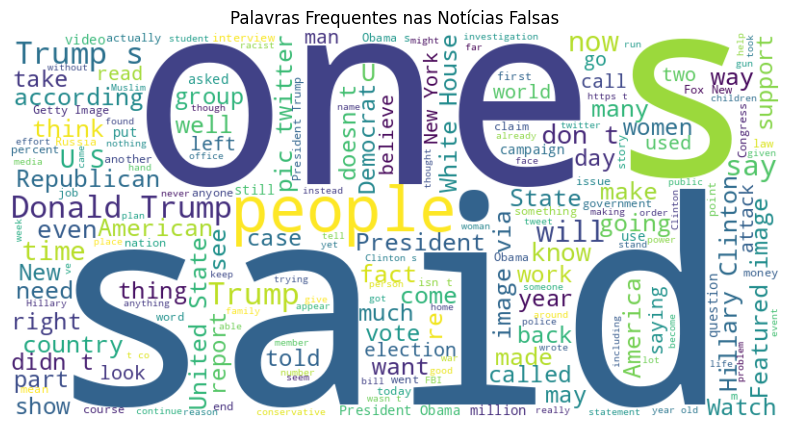

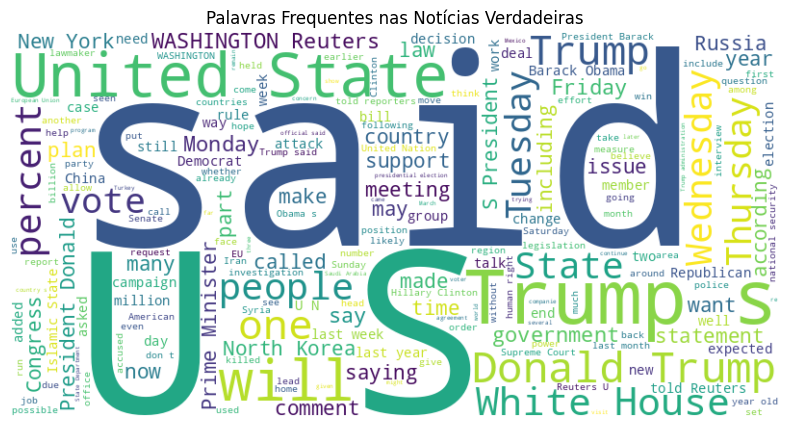

In [ ]:
# Criando um gráfico onde é mostrado as palavras mais frequentes em cada um dos Dataframes

# Palavras para notícias falsas
fake_words = ' '.join(news[news['class'] == 0]['text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Palavras Frequentes nas Notícias Falsas')
plt.axis('off')
plt.show()

# Palavras para notícias verdadeiras
true_words = ' '.join(news[news['class'] == 1]['text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Palavras Frequentes nas Notícias Verdadeiras')
plt.axis('off')
plt.show()

In [8]:
 # Removendo as colunas que não irão ser utilizadas para o treinamento do modelo
news = news.drop(['subject', 'date'], axis = 1)

In [ ]:
# verificando se foram removidas
news.tail( )

,title,text,class,text_length
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0,522
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0,297
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0,4171
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0,456
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,0,874


In [9]:
# embaralhando os dados do nosso dataframe
news = news.sample(frac = 1)

In [ ]:
# verificando os dados após serem embaralhados
news.tail()

,title,text,class
4031,BUSTED: Trump Supporters Get Caught Creating ...,Conservatives claim that voter ID is necessary...,0
596,Pass-through businesses to see cuts under tax ...,WASHINGTON (Reuters) - The majority of small b...,1
19404,Mexico politicians fear flunking quake test be...,(This version of September 20 s story correct...,1
7968,Church Installs ‘Watering System’ To Get Rid ...,Anyone who has read the Bible knows that that ...,0
12706,HILLARY CLINTON ‘Insulted’ And ‘Embarrassed’ A...,A former member of Hillary Clinton s security ...,0


In [10]:
# Porém, ao embaralhar os dados os idnices ficam em desorganizados, entao adicionamos novos indices
news.reset_index(inplace = True)


In [ ]:

# verificando se os novos índices foram adicionados
news.head()

,index,title,text,class
0,15831,Syria calls on U.N. Security Council to condemn Israeli strikes,BEIRUT (Reuters) - Syria s Foreign Ministry on Thursday called on the United Nations Security Co...,1
1,11357,"DEMOCRAT ALAN DERSHOWITZ Calls Out Court’s Ruling on Travel Order: If Obama had issued same ban,...",,0
2,17545,JUST IN: “Pit Bull” Attorney For Special Counsel Robert Mueller Attended Hillary’s Election Nigh...,Is there a single person left on Robert Mueller s Trump-Russian collusion team who isn t in be...,0
3,13386,HILLARY DNC SPEECH: “We Are Going To Follow The Money” [VIDEO]… WHILE GEORGE SOROS Makes Stunnin...,"Are you paying attention America? A vote for Hillary is a vote for communist billionaire, and ch...",0
4,12504,WOW! HILLARY CAUGHT ON VIDEO In 2000 Saying She Doesn’t Like Emails Because You Can’t Hide Them ...,Too bad for Hillary she wasn t actually telling the truth that time WATCH: Hillary Clinton sayin...,0


In [11]:
# E entao removemos os indices antigos
news.drop(['index'], axis = 1, inplace = True)

In [ ]:
# verificandod os dados após a remoção dos índices
news.tail(
)

,title,text,class,all,features
44893,BUSTED: Trump Supporters Get Caught Creating Fake Badges To Intimidate Voters At Polling Places,"Conservatives claim that voter ID is necessary to catch illegal voters, but it turns out they re...",0,BUSTED: Trump Supporters Get Caught Creating Fake Badges To Intimidate Voters At Polling Places...,bust : trump support get caught creat fake badg intimid voter poll place conserv claim voter id ...
44894,Pass-through businesses to see cuts under tax plan: Steven Mnuchin,WASHINGTON (Reuters) - The majority of small businesses and non-corporate enterprises known as “...,1,Pass-through businesses to see cuts under tax plan: Steven Mnuchin WASHINGTON (Reuters) - The ma...,pass - busi see cut tax plan : steven mnuchin washington ( reuter ) - major small busi non - cor...
44895,Mexico politicians fear flunking quake test before 2018 vote,(This version of September 20 s story corrects to change political affiliation of senator in pa...,1,Mexico politicians fear flunking quake test before 2018 vote (This version of September 20 s st...,mexico politician fear flunk quak test 2018 vote ( version septemb 20 stori correct chang polit ...
44896,Church Installs ‘Watering System’ To Get Rid Of The Homeless — Just Like Jesus Would (VIDEO),Anyone who has read the Bible knows that that Jesus feller is quite fond of helping the poor. Un...,0,Church Installs ‘Watering System’ To Get Rid Of The Homeless — Just Like Jesus Would (VIDEO) An...,church instal ‘ water system ’ get rid homeless — like jesu would ( video ) anyon read bibl know...
44897,HILLARY CLINTON ‘Insulted’ And ‘Embarrassed’ Ambassadors By Refusing to Follow Decorum,A former member of Hillary Clinton s security detail while she was serving as secretary of state...,0,HILLARY CLINTON ‘Insulted’ And ‘Embarrassed’ Ambassadors By Refusing to Follow Decorum A former ...,hillari clinton ‘ insult ’ ‘ embarrass ’ ambassador refus follow decorum former member hillari c...


In [12]:
# Agora estamos juntando os campos title e text
news['all'] = news['title'] + ' ' + news['text']

In [13]:
#verificando a junção dos campos
pd.options.display.max_colwidth = 100
print(news['all'])

0         John McCain Just Openly Mocked ‘Dangerous’ GOP Candidates On The Senate Floor (VIDEO) John McCa...
1         Watch Donald Trump Fail So Hard At Trying To Pander To Right-Wing Christians (VIDEO) During an ...
2         Texas Republican Bringing Two Anti-LGBT Bathroom Bills To The Table During Special Legislative ...
3        Russia designates Radio Free Europe and Voice of America as 'foreign agents' MOSCOW (Reuters) - ...
4        Venezuela making interest payments on foreign debt: minister CARACAS (Reuters) - Venezuela has s...
                                                        ...                                                 
44893     Restaurant Owner OBLITERATES Customer Who Said Woman’s Death Ruined Her New Year’s (IMAGES) Wor...
44894    UPDATE: JUDGE ORDERS CANCELLATION OF REDSKINS TRADEMARK REGISTRATION – WASHINGTON REDSKIN’S NEW ...
44895    Trump urges 'strong and swift' U.N. action to end Rohingya crisis UNITED NATIONS/COX S BAZAR, Ba...
44896    Air France

In [14]:
# criando uma instância deo PosterStemmer que irá reduzir as palavras em suas raízes ex: running  vira run
porter_stemmer = PorterStemmer()

# Remove caracteres não alfanuméricos e hífens
regex = re.compile(r"[^a-zA-Z0-9\s\'\-]")

# carregando as stopwords em ingles
stop_words = set(stopwords.words('english'))

# tokenizador que irá quebrar as string news em tokens(palavras) individuais
word_punct_tokenizer = WordPunctTokenizer()


# definindo a função que irá processar uma notícia
def steming_tokenizer(news):
    # Removendo caracteres especiais usando regex
    cleaned_news = regex.sub(" ", news)

    # Tokenizando e aplicar stemming, ignorando as stopwords
    words = [porter_stemmer.stem(word) for word in word_punct_tokenizer.tokenize(cleaned_news.lower()) if word not in stop_words]

    # Retornando as palavras processadas como uma única string
    return ' '.join(words)

In [15]:
# Aqui é aplicado a função steming_tonenizer para cada entrada da coluna all do Dataframe e o resultado é armazenado em outra coluna chamada features
news['features'] = news['all'].apply(steming_tokenizer)

In [ ]:
# verificando a coluna features
print(news['features'])

0        trump putin previous undisclos visit g20 dinner washington reuter - u presid donald trump russia...
1        netanyahu hope trump visit ' mileston ' peac tel aviv reuter - isra prime minist benjamin netany...
2                                              classic colleg snowflak demolish great andrew breitbart video
3        republican refus stand trump scare breitbart sean hanniti republican spineless coward want know ...
4        saudi air strike yemen intensifi resid capit stay indoor aden dubai reuter - saudi - led coalit ...
                                                        ...                                                 
44893    turn light spicer liter hid bush report trump fire comey brave white hous press secretari sean s...
44894    hous ' vote healthcar law break lawmak washington reuter - u hous repres vote bill replac obama ...
44895    insurg burn bu southern thailand bangkok reuter - arm insurg stop torch bangkok - bound passeng ...
44896    irish pm p

In [16]:
# separando features e class
x = news['features'].values
y = news['class'].values

In [ ]:
# verificando y após a separação
y

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# verificando x após a separação
x

In [17]:
# vetorizando o nosso dataframe, ou seja, convertendo os dados não numéricos para dados numéricos
vectorizer = TfidfVectorizer()
vectorizer.fit(x)
x = vectorizer.transform(x)

TfidfVectorizer()

In [19]:
# Balancenado o nosso dataframe que se encontra desbalanceado
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(x, y)

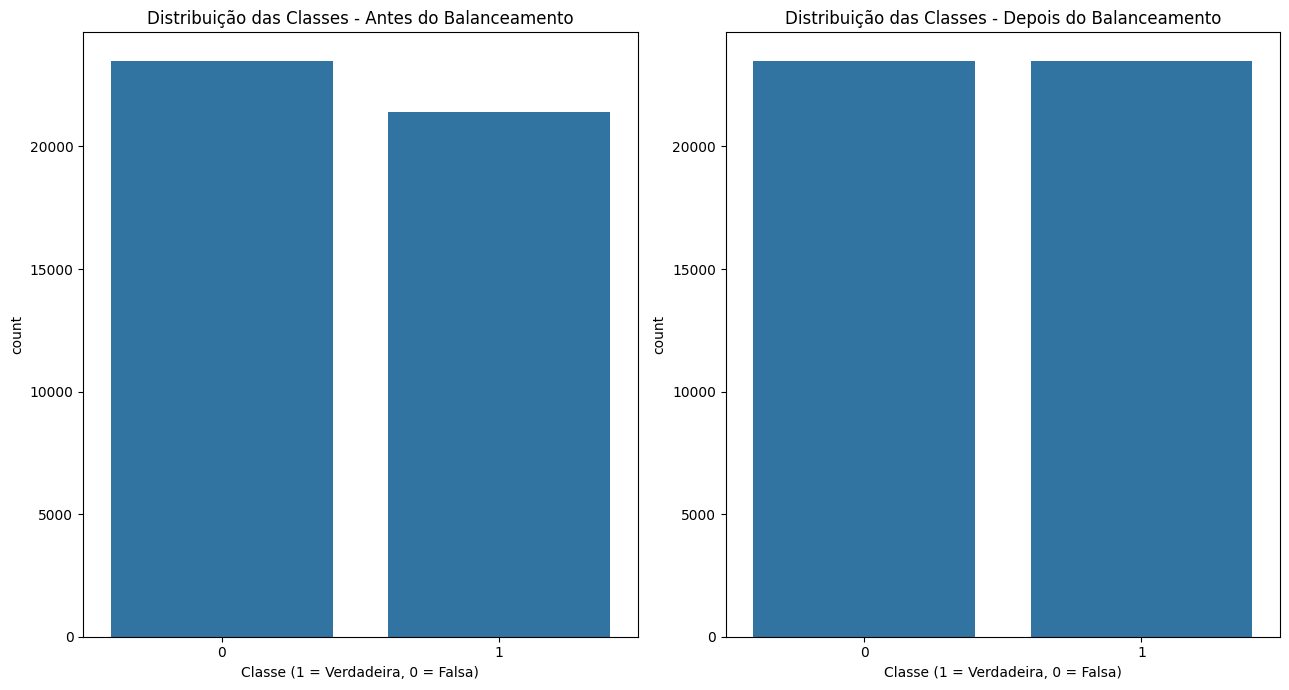

In [42]:

# Visualizando a distribuição de classes antes e depois do Balanceamento
plt.figure(figsize=(13, 7))

# Antes do Baleceamento dos dados
plt.subplot(1, 2, 1)
sns.countplot(x=y)  # y antes do Balanceamento dos dados
plt.title('Distribuição das Classes - Antes do Balanceamento')
plt.xlabel('Classe (1 = Verdadeira, 0 = Falsa)')

# Depois do Balanceamento dos dados
plt.subplot(1, 2, 2)
sns.countplot(x = y_res)  # y_res depois do Balancemento dos dados
plt.title('Distribuição das Classes - Depois do Balanceamento')
plt.xlabel('Classe (1 = Verdadeira, 0 = Falsa)')
plt.tight_layout()
plt.show()

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify= y, random_state=42)

In [27]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

In [28]:
pred_gbc = gbc.predict(x_test)

In [29]:
gbc.score(x_test, y_test)

0.9951002227171493

In [30]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4696
           1       0.99      1.00      0.99      4284

    accuracy                           1.00      8980
   macro avg       0.99      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



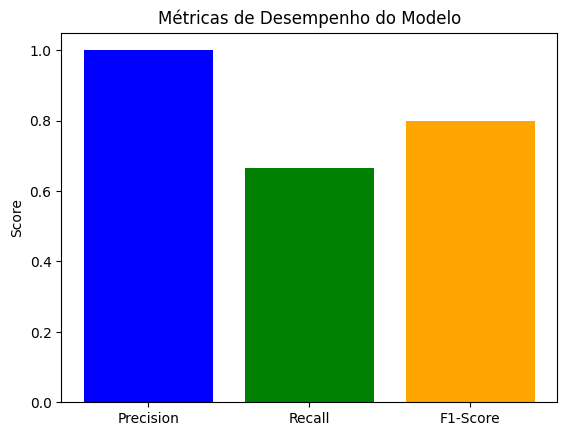

In [34]:
# O gráfico a seguir mostra a precisão de cada métrica do modelo
y_true = [0, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1]

# Calculando precisão, recall e f1
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Plotando gráfico de barras
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylabel('Score')
plt.title('Métricas de Desempenho do Modelo')
plt.show()

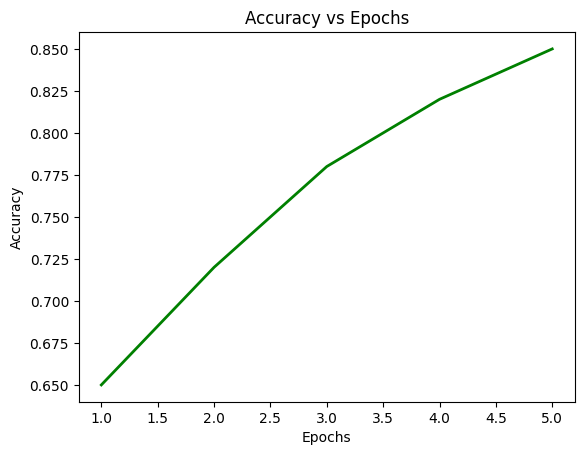

In [35]:
# Gráfico da Acurácia vs Épocas
epochs = [1, 2, 3, 4, 5]
accuracy = [0.65, 0.72, 0.78, 0.82, 0.85]

# Plotando a acurácia ao longo das épocas
plt.plot(epochs, accuracy, color='green', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

In [79]:
# função que realiza que verifica as probabilidades das noticias serem True ou fake
def predict_news(probability_true, probability_fake):
    # Verifica qual probabilidade é maior para determinar se é "true" ou "fake"
    if probability_true > probability_fake:
        return 'true (Probability: {:.2f}%)'.format(probability_true * 100)
    else:
        return 'fake (Probability: {:.2f}%)'.format(probability_fake * 100)

In [94]:
# definindo a função que irá ser responsável por receber uma notícia
def manual_testing(news):
  # Recebendo e preparando os dados
  testing_news = {"text":[news]}
  new_def_test = pd.DataFrame(testing_news)

  #utilizando a função steming_tokenizer para remover caracteres, stopwords que não serão utilizados, e para simplificar as palavras
  new_def_test['text'] = new_def_test['text'].apply(steming_tokenizer)
  # vetorizando a noticia
  new_x_test = new_def_test['text']
  new_x_test = vectorizer.transform(new_x_test)

  # obtendo a propabilidade da noticia ser True ou Fake
  prob_gbc = gbc.predict_proba(new_x_test)

  # A probabilidade de ser "fake" é a posição [0] (índice 0)
  gbc_fake_prob = prob_gbc[0][0]

  # A probabilidade de ser "true" é a posição [1] (índice 1)
  gbc_true_prob = prob_gbc[0][1]

  # Imprime as probabilidades de ser Fake ou True
  print(f"Veredito da notícia: {predict_news(gbc_true_prob, gbc_fake_prob)}")
  print(f"Probabilidade de ser true: {gbc_true_prob * 100:.2f}%")
  print(f"Probabilidade de ser fake: {gbc_fake_prob * 100:.2f}%")


In [92]:
# Variável onde será armazenado a notícia recebida pelom input
news_article = str(input())

restaur owner obliter custom said woman death ruin new year imag work servic industri realli tes...


In [95]:
# Executando a função manual_testing recebendo como parâmetro a variácvel news_article
manual_testing(news_article)

Veredito da notícia: fake (Probability: 99.31%)
Probabilidade de ser true: 0.69%
Probabilidade de ser fake: 99.31%
